In [2]:
import datetime

In [4]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from transformers import BertTokenizer
from nltk.util import ngrams
import spacy
import re

# Load Data
train = pd.read_csv('../public_data/train/track_a/eng.csv')
val = pd.read_csv('../public_data/dev/track_a/eng_a.csv')
emotions = ['Joy', 'Sadness', 'Surprise', 'Fear', 'Anger']

# Preprocessing Config
config = {'sep_pn': True, 'rm_pn': False, 'apply_lemmatization': True, 'apply_stemming': True, 'add_bigrams': True, 'rm_sw': False}

# Preprocessing Functions
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
nlp = spacy.load("en_core_web_sm")

def pre_process(text, config):
    def separate_punctuation(text):
        text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text)
        text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text)
        return text

    def remove_punctuation(text):
        text = re.sub(r"[.,;:!?'\"“”\(\)]", "", text)
        return text

    def tokenize_text(text):
        encoded_input = tokenizer(text, return_tensors='pt', add_special_tokens=True)
        tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0])
        return tokens

    def apply_stemming(tokens):
        stemmer = PorterStemmer()
        return [stemmer.stem(token) for token in tokens]

    def apply_lemmatization(tokens):
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(token) for token in tokens]

    def generate_ngrams_from_tokens(tokens, n):
        return [" ".join(gram) for gram in ngrams(tokens, n)]

    # Apply config options
    if config['sep_pn'] and not config['rm_pn']:
        text = separate_punctuation(text)
    if config['rm_pn'] and not config['sep_pn']:
        text = remove_punctuation(text)

    tokens = tokenize_text(text)
    if config['apply_stemming']:
        tokens = apply_stemming(tokens)
    if config['apply_lemmatization']:
        tokens = apply_lemmatization(tokens)
    if config['add_bigrams']:
        tokens += generate_ngrams_from_tokens(tokens, 2)
    if config['rm_sw']:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word.lower() not in stop_words]

    return " ".join(tokens)

# Preprocess and Extract Features
vectorizer = CountVectorizer()

train_text = [pre_process(text, config) for text in train["text"]]
val_text = [pre_process(text, config) for text in val["text"]]

X_train = vectorizer.fit_transform(train_text).toarray()
X_val = vectorizer.transform(val_text).toarray()

# POS Tagging
def extract_pos_tags(texts):
    return [[token.pos_ for token in nlp(text)] for text in texts]

train_pos_tags = extract_pos_tags(train["text"])
val_pos_tags = extract_pos_tags(val["text"])

# POS Encoding
max_length = max(max(len(tags) for tags in train_pos_tags), max(len(tags) for tags in val_pos_tags))
train_pos_tags = [tags + ['PAD'] * (max_length - len(tags)) for tags in train_pos_tags]
val_pos_tags = [tags + ['PAD'] * (max_length - len(tags)) for tags in val_pos_tags]

encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
train_pos_encoded = encoder.fit_transform(train_pos_tags)
val_pos_encoded = encoder.transform(val_pos_tags)

# Combine Features
combined_features = np.concatenate((X_train, train_pos_encoded), axis=1)
validation_combined_features = np.concatenate((X_val, val_pos_encoded), axis=1)

# Logistic Regression for Enhanced Features
y_train = train[emotions].values
lr = LogisticRegression(max_iter=1000)
lr.fit(combined_features, np.argmax(y_train, axis=1))

lr_features = lr.predict_proba(combined_features)
val_lr_features = lr.predict_proba(validation_combined_features)

final_train_features = np.concatenate((combined_features, lr_features), axis=1)
final_val_features = np.concatenate((validation_combined_features, val_lr_features), axis=1)

# Neural Network
model = nn.Sequential(
    nn.Linear(final_train_features.shape[1], 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1])
)

# DataLoader
features_tensor = torch.tensor(final_train_features, dtype=torch.float32)
labels_tensor = torch.tensor(y_train, dtype=torch.float32)
dataset = TensorDataset(features_tensor, labels_tensor)
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

weights = y_train.sum(axis=0)/y_train.sum()
weights = max(weights)/weights

# Loss and Optimizer
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor(weights)) # <-- weights assigned to optimiser
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-4)

# Training Loop
losses = []
for epoch in tqdm(range(1000), desc="Training Loop"):
    for features, labels in data_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    # if epoch % 100 == 0:
    #     print(f"Epoch {epoch}: Loss: {round(loss.item(), 3)}")
    # losses.append(loss.item())
    if epoch % 100 == 0:
        print(f'Epoch {epoch}: Loss: {round(loss.item(),3)}')
        # Save the trained model's weights for future use.
        torch.save(model.state_dict(), f'./21-12-24(1)/net_epoch_{epoch}.pth')
        print(f"Saved epoch {epoch} weights to './21-12-24(1)/net_epoch_{epoch}.pth'")
        losses.append(round(loss.item(),3))
    if epoch == 1000:
        print(f'Epoch {epoch}: Loss: {round(loss.item(),3)}')
        # Save the trained model's weights for future use.
        torch.save(model.state_dict(), f'./21-12-24(1)/net_epoch_{epoch}.pth')
        print(f"Saved epoch {epoch} weights to './21-12-24(1)/net_epoch_{epoch}.pth'")
        losses.append(round(loss.item(),3))

Training Loop:   0%|          | 1/1000 [00:02<47:56,  2.88s/it]

Epoch 0: Loss: 0.928
Saved epoch 0 weights to './21-12-24(1)/net_epoch_0.pth'


Training Loop:  10%|█         | 101/1000 [03:09<30:47,  2.06s/it]

Epoch 100: Loss: 0.013
Saved epoch 100 weights to './21-12-24(1)/net_epoch_100.pth'


Training Loop:  20%|██        | 201/1000 [06:25<23:04,  1.73s/it]

Epoch 200: Loss: 0.005
Saved epoch 200 weights to './21-12-24(1)/net_epoch_200.pth'


Training Loop:  30%|███       | 301/1000 [09:20<14:28,  1.24s/it]

Epoch 300: Loss: 0.003
Saved epoch 300 weights to './21-12-24(1)/net_epoch_300.pth'


Training Loop:  40%|████      | 401/1000 [12:22<18:49,  1.89s/it]

Epoch 400: Loss: 0.001
Saved epoch 400 weights to './21-12-24(1)/net_epoch_400.pth'


Training Loop:  50%|█████     | 501/1000 [15:11<16:10,  1.94s/it]

Epoch 500: Loss: 0.0
Saved epoch 500 weights to './21-12-24(1)/net_epoch_500.pth'


Training Loop:  60%|██████    | 601/1000 [18:31<13:45,  2.07s/it]

Epoch 600: Loss: 0.003
Saved epoch 600 weights to './21-12-24(1)/net_epoch_600.pth'


Training Loop:  70%|███████   | 701/1000 [21:16<05:42,  1.15s/it]

Epoch 700: Loss: 0.006
Saved epoch 700 weights to './21-12-24(1)/net_epoch_700.pth'


Training Loop:  80%|████████  | 801/1000 [23:10<03:33,  1.07s/it]

Epoch 800: Loss: 0.001
Saved epoch 800 weights to './21-12-24(1)/net_epoch_800.pth'


Training Loop:  90%|█████████ | 901/1000 [25:09<01:38,  1.00it/s]

Epoch 900: Loss: 0.002
Saved epoch 900 weights to './21-12-24(1)/net_epoch_900.pth'


Training Loop: 100%|██████████| 1000/1000 [26:58<00:00,  1.62s/it]


In [6]:
# Final Loss
print(f"Final Loss after 1000 epochs: {losses[-1]}")

Final Loss after 1000 epochs: 0.002


In [8]:
final_val_features, losses

(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.37153346e-03, 2.03434673e-04, 1.06744582e-04],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.01568564e-02, 3.33009357e-01, 2.31915457e-04],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.26728178e-02, 9.27401246e-03, 1.08520154e-03],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         4.98633799e-03, 3.81255445e-01, 1.96406709e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.88115472e-01, 4.96022926e-02, 7.41382697e-03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.32888115e-01, 2.58945858e-03, 1.28381599e-02]]),
 [0.928, 0.013, 0.005, 0.003, 0.001, 0.0, 0.003, 0.006, 0.001, 0.002])

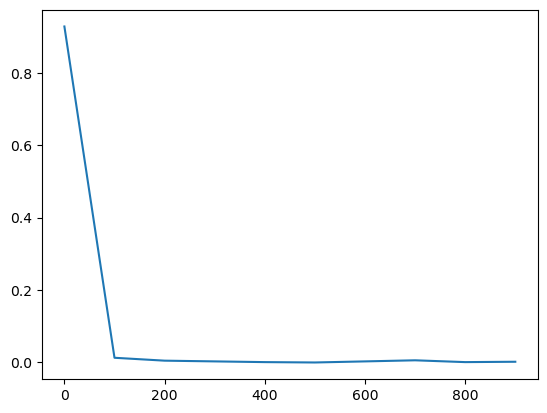

In [9]:
import matplotlib.pyplot as plt

eps = [100*i for i in range(0,10)]

plt.plot(eps, losses)

In [11]:
def get_predictions(X_val, model, threshold=0.5):
    sig = nn.Sigmoid() 
    yhat = sig(model(X_val)).detach().numpy()
    y_pred = yhat > threshold
    
    return y_pred

# y_pred = get_predictions(torch.Tensor(final_val_features), model, 0.45)
# # print(y_pred)

# # Create a DataFrame to save to CSV
# val_data_with_pred = pd.DataFrame(y_pred, columns=['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise'])  # Adjust column names as per your features
# # val_data_with_pred['True_Label'] = y_test
# # val_data_with_pred['Predictions'] = dummy_predictions

# val_data_with_pred = val_data_with_pred.astype(int)

# val_data_with_pred['id'] = val['id']

# val_data_with_pred = val_data_with_pred[['id', 'Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']]

# # Save to CSV
# current_time = datetime.datetime.now()
# formatted_time = current_time.strftime('%Y-%m-%d_%H_%M_%S')

# val_data_with_pred.to_csv(f'../results/pred_eng_a_{formatted_time}.csv', index=False)

# print(val_data_with_pred)

In [13]:
# DO 10 different prediction files with epochs 100, 200, 300, 400, 500, 600, 700, 800, 900 and 1000 Model parameters

# Get 10 differen prediction files

for i in range(10):
    epoch = i*100
    model.load_state_dict(torch.load(f'./21-12-24(1)/net_epoch_{epoch}.pth', weights_only=True))
    y_pred = get_predictions(torch.Tensor(final_val_features), model, 0.45)
    # print(y_pred)

    # Create a DataFrame to save to CSV
    val_data_with_pred = pd.DataFrame(y_pred, columns=['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise'])  # Adjust column names as per your features
    # val_data_with_pred['True_Label'] = y_test
    # val_data_with_pred['Predictions'] = dummy_predictions

    val_data_with_pred = val_data_with_pred.astype(int)

    val_data_with_pred['id'] = val['id']

    val_data_with_pred = val_data_with_pred[['id', 'Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']]

    # Save to CSV
    current_time = datetime.datetime.now()
    formatted_time = current_time.strftime('%Y-%m-%d_%H_%M_%S')

    val_data_with_pred.to_csv(f'../results/alt4_2/alt4_epoch_{epoch}_pred_eng_a_{formatted_time}.csv', index=False)

    print(val_data_with_pred)

                        id  Anger  Fear  Joy  Sadness  Surprise
0    eng_dev_track_a_00001      1     1    0        1         0
1    eng_dev_track_a_00002      1     1    1        1         0
2    eng_dev_track_a_00003      1     1    0        1         0
3    eng_dev_track_a_00004      1     0    0        1         0
4    eng_dev_track_a_00005      1     1    0        0         0
..                     ...    ...   ...  ...      ...       ...
111  eng_dev_track_a_00112      1     1    1        1         0
112  eng_dev_track_a_00113      1     1    1        1         0
113  eng_dev_track_a_00114      1     1    0        1         0
114  eng_dev_track_a_00115      1     1    1        1         0
115  eng_dev_track_a_00116      1     1    1        1         0

[116 rows x 6 columns]
                        id  Anger  Fear  Joy  Sadness  Surprise
0    eng_dev_track_a_00001      0     1    0        0         0
1    eng_dev_track_a_00002      0     1    0        1         0
2    eng_dev_tra

1. For Submission 5 files:

    Your results for eng track A are:

    Multi-label accuracy (Jaccard score): 0.26063218390804593

    Micro F1 score: 0.41758241758241754

    Macro F1 score: 0.36549662349391404

2. For Submission 6 files:

    Your results for eng track A are:

    Multi-label accuracy (Jaccard score): 0.26206896551724135

    Micro F1 score: 0.42659279778393355

    Macro F1 score: 0.36911780259117266

| Epoch | Jaccard Index | Micro F1 | Macro F1 |
| ----- | ------------- | -------- | -------- |
| 0     |               |          |          |
| 100   |               |          |          |
| 200   |               |          |          |
| 300   |               |          |          |
| 400   |               |          |          |
| 500   |               |          |          |
| 600   |               |          |          |
| 700   |               |          |          |
| 800   |               |          |          |
| 900   |               |          |          |
| 1000  |               |          |          |